In [1]:
from posteriordb import PosteriorDatabase

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, vmap, jit
import jax.numpy as jnp
import jax

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model

# from numpyro.diagnostics import hpdi

from AMH import AMH, AMHAdaptState
from evaluation import wasserstein_1d, wasserstein_dist11_p

In [2]:
svg_dir = "../img/svg/"

# 1. Univariate distribution

In [3]:
normal_dist = dist.Normal(0, 1)
potential_fn = lambda x: -1 *normal_dist.log_prob(x)

kernel = AMH(potential_fn=potential_fn)

In [4]:
def get_adapt_state(cov_matrix):
    return AMHAdaptState(
        mean=jnp.array([0]),
        covariance=cov_matrix,
        log_step_size=jnp.array(0)
    )


In [5]:
rng_key = random.PRNGKey(0)

# k1, k2 = random.split(rng_key)
# s1 = sample_adapt_state(k1)
# s2 = sample_neigbour(k2, s1, eps=0.1)
# s3 = sample_neigbour(k2, s1, eps=1)

s1 = get_adapt_state(jnp.array([[1.]]))
s2 = get_adapt_state(jnp.array([[1e-1]]))
s3 = get_adapt_state(jnp.array([[1e1]]))


sample_dist1 = dist.MultivariateNormal(loc=s1.mean, covariance_matrix=jnp.exp(s1.log_step_size)*s1.covariance)
sample_dist2 = dist.MultivariateNormal(loc=s2.mean, covariance_matrix=jnp.exp(s2.log_step_size)*s2.covariance)
sample_dist3 = dist.MultivariateNormal(loc=s3.mean, covariance_matrix=jnp.exp(s3.log_step_size)*s3.covariance)

# state_dist(s1, s2)

In [6]:
s1, s2, s3

(AMHAdaptState(mean=Array([0], dtype=int32), covariance=Array([[1.]], dtype=float32), log_step_size=Array(0, dtype=int32, weak_type=True)),
 AMHAdaptState(mean=Array([0], dtype=int32), covariance=Array([[0.1]], dtype=float32), log_step_size=Array(0, dtype=int32, weak_type=True)),
 AMHAdaptState(mean=Array([0], dtype=int32), covariance=Array([[10.]], dtype=float32), log_step_size=Array(0, dtype=int32, weak_type=True)))

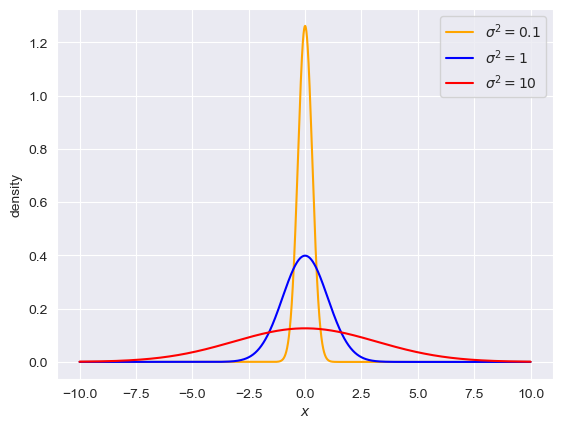

In [7]:
x_dist = jnp.arange(-10, 10, .002)
# plt.hist(mcmc.get_samples(), bins=50, density=True, label="samples")

# plt.plot(x_dist, jnp.exp(normal_dist.log_prob(x_dist)), color="green", label=r"target $\pi$")

plt.plot(x_dist, jnp.exp(vmap(sample_dist2.log_prob)(x_dist)), color='orange', label=r"$\sigma^2 = 0.1$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist1.log_prob)(x_dist)), color='blue', label=r"$\sigma^2 = 1$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist3.log_prob)(x_dist)), color='red', label=r"$\sigma^2 = 10$")


plt.ylabel("density")
plt.xlabel("$x$")
plt.legend()
# plt.savefig(svg_dir + "univariate-normal.svg", format="svg")

## 1.2. Sampling from $P(x, \cdot)$

In [8]:
rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)

In [24]:
%%time 

N = 100000

P1x = kernel.sample_Px(rng_key, kernel, X, s1, n_samples=N).squeeze()
# P2x = sample_Px(rng_key, kernel, X, s2, N).squeeze()
# P3x = sample_Px(rng_key, kernel, X, s3, N).squeeze()


NameError: name 'sample_Px' is not defined

In [25]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

# dP2x = P2x - X
# dP2x_mean = dP2x.mean(axis=1)
# dP2x_acc_mean = dP1x.mean(axis=1, where=(dP2x != 0.0))
# P2x_lower = jnp.quantile(dP2x, 0.05, axis=1)
# P2x_upper = jnp.quantile(dP2x, 0.95, axis=1)
# # P2x_lower, P2x_upper = hpdi(dP2x , prob=0.99, axis=1).reshape(2, -1)

NameError: name 'P1x' is not defined

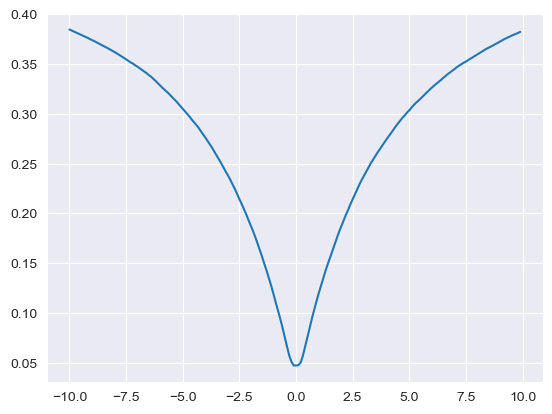

In [54]:
plt.plot(x, jnp.mean(dP1x == 0.0, axis=1))

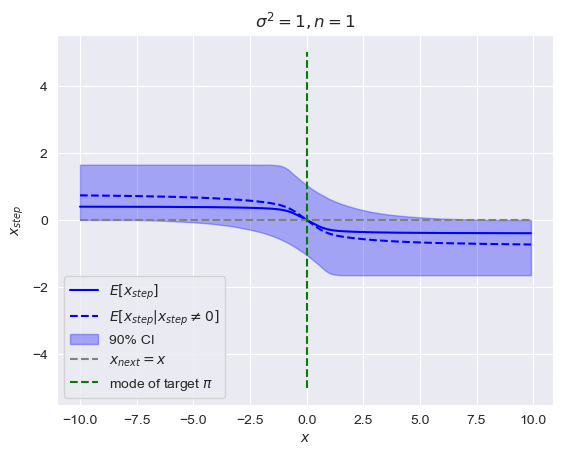

In [71]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=1$")

ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
# ax2.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")

plt.savefig(svg_dir + "univariate-x-step-cov1-n1.svg", format="svg")

In [59]:
%%time 

N = 10000
n = 5

P1x = sample_Pnx(rng_key, kernel, X, s1, n, N).squeeze()
# P2x = sample_Pnx(rng_key, kernel, X, s2, n, N).squeeze()

CPU times: user 535 ms, sys: 25.3 ms, total: 560 ms
Wall time: 264 ms


In [60]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

# dP2x = P2x - X
# dP2x_mean = dP2x.mean(axis=1)
# dP2x_acc_mean = dP1x.mean(axis=1, where=(dP2x != 0.0))
# P2x_lower = jnp.quantile(dP2x, 0.05, axis=1)
# P2x_upper = jnp.quantile(dP2x, 0.95, axis=1)
# P2x_lower, P2x_upper = hpdi(dP2x , prob=0.99, axis=1).reshape(2, -1)

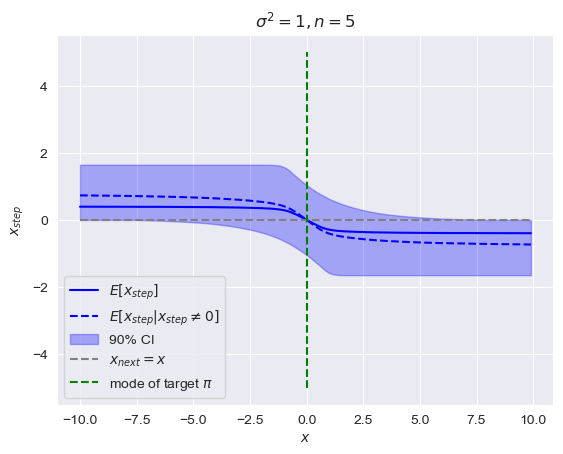

In [72]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")
ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2^5$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2^5$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
# ax2.vlines(0, -10, 10, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")
plt.savefig(svg_dir + "univariate-x-step-cov1-n5.svg", format="svg")

## 1.3. Invariance Property

In [73]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = normal_dist.sample(ks, sample_shape=(1000,1))

P1pi = kernel.sample_Pnx(k1, dist_samples, s1, n_samples=1000).flatten()
# P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1000).flatten()

CPU times: user 530 ms, sys: 19.6 ms, total: 549 ms
Wall time: 298 ms


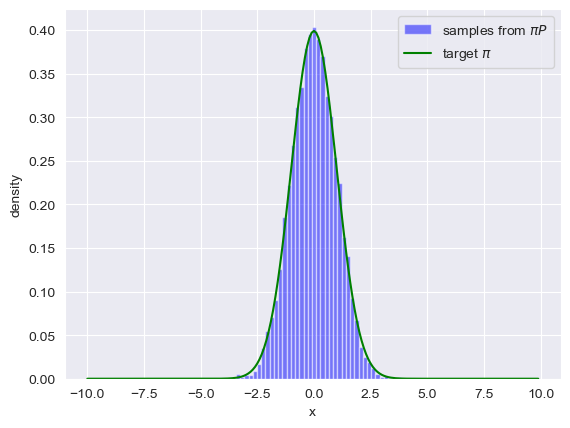

In [76]:
plt.hist(P1pi, bins=50, density=True, alpha=0.5, color="blue", label=r"samples from $\pi P$")
# plt.hist(P2pi, bins=50, density=True, alpha=0.5, label=r"samples from $\pi P_2$")
plt.plot(x, jnp.exp(normal_dist.log_prob(x)), color="green", label=r"target $\pi$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
# plt.savefig(svg_dir + "univariate-invariance.svg", format="svg")

## 1.4. Contraction Property

In [8]:
def get_taus_n(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 1000):
    Pnx = kernel.sample_Pnx(rng_key, X, adapt_state, n, n_samples).squeeze()

    W_dists_n = vmap(wasserstein_1d)(Pnx[:-2], Pnx[2:])
    diffs = jnp.abs(x[:-2] - x[2:])
    
    taus_n = W_dists_n / diffs
    
    return x[1:-1], taus_n

In [9]:
# def rolling_average(arr, window_size):
#     if window_size < 1:
#         raise ValueError("Window size must be at least 1")
#     
#     # Define the kernel (uniform weights)
#     kernel = jnp.ones(window_size) / window_size
#     
#     # Compute the moving average using 'valid' mode to avoid padding issues
#     return jnp.convolve(arr, kernel, mode='valid') # Remove extra dimensions

In [11]:
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 100000

x_vals1, taus1 = get_taus_n(rng_key, kernel, X, s1, n=1, n_samples=N)
# x_vals2, taus2 = get_taus_n(rng_key, kernel, X, s1, n=2, n_samples=N)
x_vals5, taus5 = get_taus_n(rng_key, kernel, X, s1, n=5, n_samples=N)
x_vals10, taus10 = get_taus_n(rng_key, kernel, X, s1, n=10, n_samples=N)
x_vals25, taus25 = get_taus_n(rng_key, kernel, X, s1, n=25, n_samples=N)



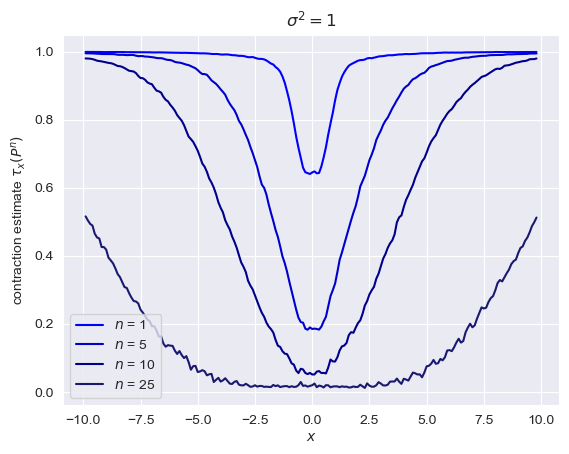

In [13]:
plt.title(r"$\sigma^2 = 1$")
plt.plot(x_vals1, taus1, color="blue", label=r"$n$ = 1")
# plt.plot(x_vals2, taus2, color="mediumblue", label=r"$n$ = 2")
plt.plot(x_vals5, taus5, color="mediumblue", label=r"$n$ = 5")
plt.plot(x_vals10, taus10, color="darkblue", label=r"$n$ = 10")
plt.plot(x_vals25, taus25, color="midnightblue", label=r"$n$ = 25")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="lower left")
# plt.savefig(svg_dir + "univariate-x-contraction.svg", format="svg")

In [8]:
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 10000

def get_max_taus(n_list, adapt_state, tau_samples=100, ci=0.9):
       
    rng_keys = random.split(rng_key, tau_samples)
    n_vals = jnp.array(n_list)
    
    @jit
    def max_tau_fn(rng_key, n):
        Pnx = kernel.sample_Pnx(rng_key, X, adapt_state, n, n_samples=N).squeeze()

        W_dists_n = vmap(wasserstein_1d)(Pnx[:-2], Pnx[2:])
        diffs = jnp.abs(x[:-2] - x[2:])
        
        taus_n = W_dists_n / diffs
        
        return taus_n.max()
        
    max_taus = vmap(
            vmap(max_tau_fn, in_axes=(None, 0), out_axes=0),  # Apply over r_keys
            in_axes=(0, None), out_axes=0  # Apply over n
        )(rng_keys, n_vals)
   
    max_taus_mean = max_taus.mean(axis=0)
    
    max_taus_ci_lower = jnp.quantile(max_taus, (1-ci)/2, axis=0)
    max_taus_ci_upper = jnp.quantile(max_taus, (1+ci)/2, axis=0)
    # max_taus_std = max_taus.std(axis=0)

    return max_taus_mean, max_taus_ci_lower, max_taus_ci_upper

In [9]:
# n_list = [1, 5, 10, 25, 50, 100]
n_list = [25, 50, 100]

max_taus_s1, max_taus_ci_lower_s1, max_taus_ci_upper_s1 = get_max_taus(n_list, s1, tau_samples=20)
# max_taus_s2, max_taus_ci_lower_s2, max_taus_ci_upper_s2 = get_max_taus(n_list, s2)
# max_taus_s3, max_taus_ci_lower_s3, max_taus_ci_upper_s3 = get_max_taus(n_list, s3)


In [ ]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s2, color='orange', label=r"$\sigma^2 = 0.1$")
ax1.fill_between(n_list, max_taus_ci_lower_s2, max_taus_ci_upper_s2, alpha=0.3, color="orange", label="90% CI")

ax1.plot(n_list, max_taus_s1, color='blue', label=r"$\sigma^2 = 1$")
ax1.fill_between(n_list, max_taus_ci_lower_s1, max_taus_ci_upper_s1, alpha=0.3, color="blue", label="90% CI")

ax1.plot(n_list, max_taus_s3, color='red', label=r"$\sigma^2 = 10$")
ax1.fill_between(n_list, max_taus_ci_lower_s3, max_taus_ci_upper_s3, alpha=0.3, color="red", label="90% CI")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\sigma^2}^n)$, log scale")

ax1.set_xticks(n_list)
# ax1.set_yticks([0.1, 0.5, 1])
ax1.semilogy()


ax1.set_xlabel("power $n$")
ax1.legend(loc="lower left")
# plt.savefig(svg_dir + "univariate-contraction-decrease.svg", format="svg")


In [12]:
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 10000

rng_key = random.PRNGKey(0)

In [12]:
x_vals, taus = get_taus_n(rng_key, kernel, X, s1, n=50, n_samples=N)

In [10]:
from metrics import compute_wasserstein_contraction

rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

def get_max_taus_dual(n_list, adapt_state, tau_samples=100, ci=0.9):
    rng_keys = random.split(rng_key, tau_samples)
    n_vals = jnp.array(n_list)

    @jit
    def taus_dual_fn(rng_key, n):
        sample_fn = lambda rng_key, x, n_samples: kernel.sample_Pnx(rng_key, x, adapt_state, n, n_samples)
        tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X)
        return tau

    max_taus_dual = vmap(
        vmap(taus_dual_fn, in_axes=(None, 0), out_axes=0),  # Apply over rng_keys
        in_axes=(0, None), out_axes=0  # Apply over n_vals
    )(rng_keys, n_vals)

    taus_mean = max_taus_dual.mean(axis=0)

    taus_ci_lower = jnp.quantile(max_taus_dual, (1-ci)/2, axis=0)
    taus_ci_upper = jnp.quantile(max_taus_dual, (1+ci)/2, axis=0)

    return taus_mean, taus_ci_lower, taus_ci_upper

In [11]:
max_taus_dual_s1, max_taus_dual_ci_lower_s1, max_taus_dual_ci_upper_s1  = get_max_taus_dual(n_list, s1, tau_samples=20)

In [ ]:
plt.plot(n_list, max_taus_dual_s1, '.-', color="blue", label="dual")
plt.fill_between(n_list, max_taus_dual_ci_lower_s1, max_taus_dual_ci_upper_s1, alpha=0.3, color="blue", label="90% CI")

plt.plot(n_list, max_taus_s1, '.-', color="orange", label="primal")
plt.fill_between(n_list, max_taus_ci_lower_s1, max_taus_ci_upper_s1, alpha=0.3, color="orange", label="90% CI")


# plt.semilogy()
# plt.semilogx()
plt.legend(loc="lower left")

In [29]:
sample_fn = lambda rng_key, x, n_samples: kernel.sample_Pnx(rng_key, x, s1, 50, n_samples)
tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_eval_batches=100)

In [30]:
tau

Array(0.02371517, dtype=float32)

In [115]:
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

# func = sample_lipschitz_func(random.PRNGKey(0), domain=(-10, 10), step=0.1)

func = lambda x: f(x.reshape(-1, 1))
fx = vmap(func)(x)

Pnx = sample_fn(rng_key, X, n_samples=50000)
Pnfx = vmap(func)(Pnx).mean(axis=1)

# Kernel distance

In [10]:
from metrics import compute_kernel_distance

sample_P = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s1, 1, n_samples)
sample_Q = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s2, 1, n_samples)

rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)

In [11]:
rho, f = compute_kernel_distance(sample_P, sample_Q, rng_key, X, n_samples=5000, steps=200)

Step 0, Loss: -0.6671554446220398, Grad norm: 0.0005533649818971753
Step 10, Loss: -0.7025560736656189, Grad norm: 0.006827943027019501
Step 20, Loss: -0.7053455710411072, Grad norm: 0.006397875491529703
Step 30, Loss: -0.7057971358299255, Grad norm: 0.006377199664711952
Step 40, Loss: -0.7070958614349365, Grad norm: 0.007317858748137951
Step 50, Loss: -0.7041546702384949, Grad norm: 0.005662539973855019
Step 60, Loss: -0.7071062922477722, Grad norm: 0.006836296524852514
Step 70, Loss: -0.7051123380661011, Grad norm: 0.00584377720952034
Step 80, Loss: -0.7048067450523376, Grad norm: 0.00602379348129034
Step 90, Loss: -0.7059532999992371, Grad norm: 0.006388838402926922
Step 100, Loss: -0.7064651846885681, Grad norm: 0.006562430877238512
Step 110, Loss: -0.7040368914604187, Grad norm: 0.0057345847599208355
Step 120, Loss: -0.705633282661438, Grad norm: 0.006236946675926447
Step 130, Loss: -0.7060680389404297, Grad norm: 0.0062217810191214085
Step 140, Loss: -0.7073402404785156, Grad nor

In [12]:
rho

Array(0.19459969, dtype=float32)

In [18]:
X = jnp.arange(-10, 10, 0.01).reshape(-1, 1)
x = X.squeeze()

func = lambda x: f(x.reshape(-1, 1))
# fx = vmap(func)(x)

Px = sample_P(rng_key, X, n_samples=10000)
Qx = sample_Q(rng_key, X, n_samples=10000)

Pfx = vmap(func)(Px).mean(axis=1)
Qfx = vmap(func)(Qx).mean(axis=1)

diff = Pfx - Qfx

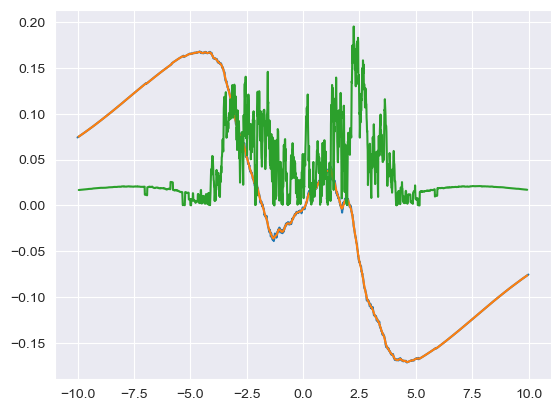

In [26]:
window_size = 11
x_rolling = rolling_average(x, window_size)
diff_smoothed = rolling_average(diff, window_size)

plt.plot(x, diff)
plt.plot(x_rolling, diff_smoothed)
plt.plot((x_rolling[:-1] + x_rolling[1:])/2, jnp.abs(jnp.diff(diff_smoothed) / jnp.diff(x_rolling)))
# plt.plot(x, Pfx)

# plt.plot(x, Qfx)

# 2. Gaussian Mixture

In [89]:
mixing_dist = dist.Categorical(probs=jnp.array([1/2, 1/2]))
component_dist = dist.Normal(loc=jnp.array([-1, 1]), scale=jnp.array([.1, .1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

In [90]:
kernel = AMH(potential_fn=potential_fn)

In [91]:
N = 100000
mixture_samples = mixture.sample(random.PRNGKey(0), (N,))
jnp.std(mixture_samples)

Array(1.0046641, dtype=float32)

Text(0.5, 0, '$x$')

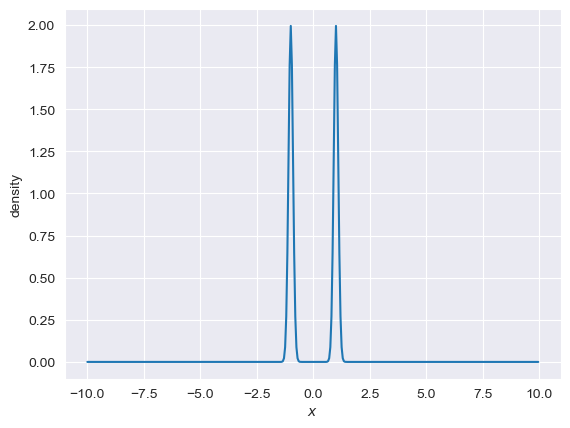

In [92]:
x= jnp.arange(-10, 10, 0.05)
plt.plot(x, jnp.exp(mixture.log_prob(x)))
plt.ylabel("density")
plt.xlabel("$x$")
# plt.legend()


## 1.2. Sampling from $P(x, \cdot)$

In [ ]:
rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.01).reshape(-1, 1)

In [111]:
%%time 

N = 10000

P1x = kernel.sample_Pnx(rng_key, X, s1, n=5, n_samples=N).squeeze()
# P2x = kernel.sample_Pnx(rng_key, kernel, X, s2, N).squeeze()

CPU times: user 372 ms, sys: 20.4 ms, total: 392 ms
Wall time: 176 ms


In [112]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

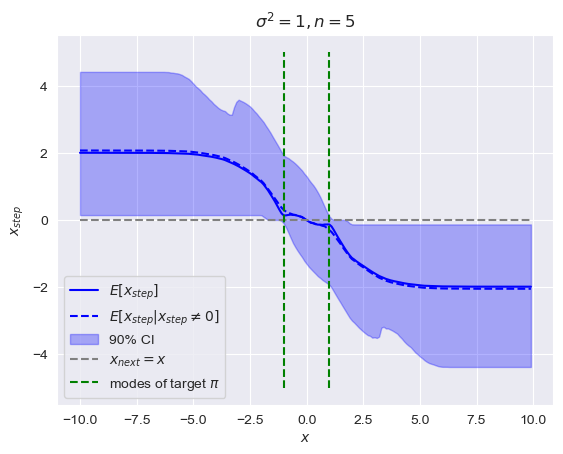

In [113]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines([-1, 1], -5, 5, linestyles='--', color="green", label=r"modes of target $\pi$")
# ax2.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")

plt.savefig(svg_dir + "mixture-x-step-cov1-n5.svg", format="svg")

## 1.3. Invariance Property

In [ ]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = mixture.sample(ks, sample_shape=(10000,1))

P1pi = sample_Px(k1, kernel, dist_samples, s1, n_samples=10000).flatten()
P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=10000).flatten()

In [ ]:
plt.hist(P1pi, bins=100, density=True, alpha=0.5, label="P1")
plt.hist(P2pi, bins=100, density=True, alpha=0.5, label="P2")
plt.plot(x, jnp.exp(mixture.log_prob(x)), label="original")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

## 1.4. Contraction Property

In [8]:
def get_taus_n(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 1000):
    Pnx = kernel.sample_Pnx(rng_key, X, adapt_state, n, n_samples).squeeze()

    W_dists_n = vmap(wasserstein_1d)(Pnx[:-2], Pnx[2:])
    diffs = jnp.abs(x[:-2] - x[2:])
    
    taus_n = W_dists_n / diffs
    
    return x[1:-1], taus_n

In [130]:
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 100000

x_vals1, taus1 = get_taus_n(rng_key, kernel, X, s1, n=1, n_samples=N)
x_vals2, taus2 = get_taus_n(rng_key, kernel, X, s1, n=2, n_samples=N)
# x_vals5, taus5 = get_taus_n(rng_key, kernel, X, s1, n=5, n_samples=N)
x_vals10, taus10 = get_taus_n(rng_key, kernel, X, s1, n=10, n_samples=N)
x_vals50, taus50 = get_taus_n(rng_key, kernel, X, s1, n=50, n_samples=N)

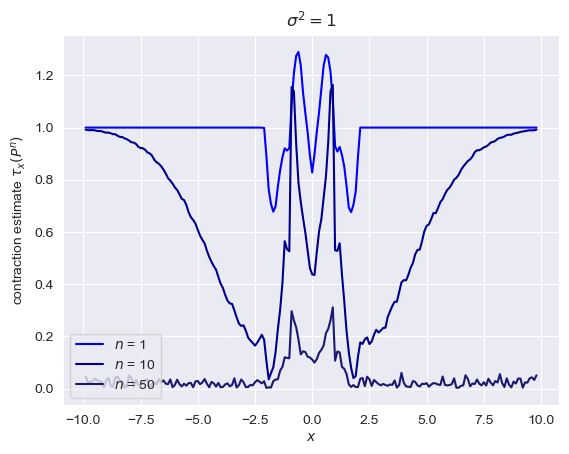

In [131]:
plt.title(r"$\sigma^2 = 1$")
plt.plot(x_vals1, taus1, color="blue", label=r"$n$ = 1")
# plt.plot(x_vals2, taus2, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x_vals5, taus5, color="darkblue", label=r"$n$ = 5")
plt.plot(x_vals10, taus10, color="darkblue", label=r"$n$ = 10")
plt.plot(x_vals50, taus50, color="midnightblue", label=r"$n$ = 50")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="lower left")
plt.savefig(svg_dir + "mixture-x-contraction.svg", format="svg")

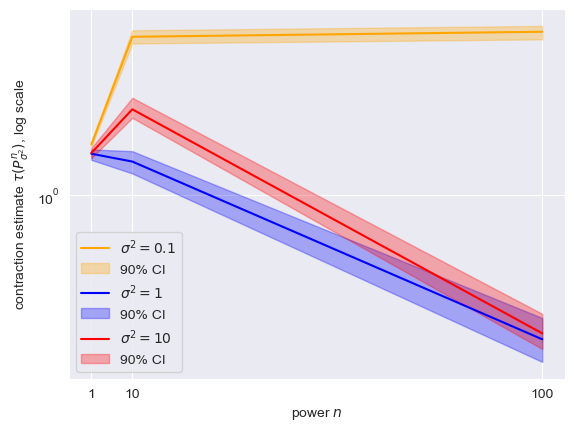

In [124]:
N = 1000

def get_max_taus(n_list, adapt_state, tau_samples=20, ci=0.9):
    rng_keys = random.split(rng_key, tau_samples)
    n_vals = jnp.array(n_list)

    def max_tau_fn(rng_key, n):
        Pnx = kernel.sample_Pnx(rng_key, X, adapt_state, n, n_samples=N).squeeze()

        W_dists_n = vmap(wasserstein_1d)(Pnx[:-2], Pnx[2:])
        diffs = jnp.abs(x[:-2] - x[2:])

        taus_n = W_dists_n / diffs

        return taus_n.max()

    @jit
    def tau_w_ci(n):
        max_taus = vmap(max_tau_fn, in_axes=(0, None))(rng_keys, n)
        return jnp.stack([
            max_taus.mean(axis=0),
            jnp.quantile(max_taus, (1 - ci) / 2, axis=0),
            jnp.quantile(max_taus, (1 + ci) / 2, axis=0)
        ])

    max_taus_mean, max_taus_ci_lower, max_taus_ci_upper = vmap(tau_w_ci, out_axes=1)(n_vals)

    return max_taus_mean, max_taus_ci_lower, max_taus_ci_upper

n_list = [1, 10, 100]

max_taus_s1, max_taus_ci_lower_s1, max_taus_ci_upper_s1 = get_max_taus(n_list, s1)
max_taus_s2, max_taus_ci_lower_s2, max_taus_ci_upper_s2 = get_max_taus(n_list, s2)
max_taus_s3, max_taus_ci_lower_s3, max_taus_ci_upper_s3 = get_max_taus(n_list, s3)

fig, ax1 = plt.subplots()
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s2, color='orange', label=r"$\sigma^2 = 0.1$")
ax1.fill_between(n_list, max_taus_ci_lower_s2, max_taus_ci_upper_s2, alpha=0.3, color="orange", label="90% CI")

ax1.plot(n_list, max_taus_s1, color='blue', label=r"$\sigma^2 = 1$")
ax1.fill_between(n_list, max_taus_ci_lower_s1, max_taus_ci_upper_s1, alpha=0.3, color="blue", label="90% CI")

ax1.plot(n_list, max_taus_s3, color='red', label=r"$\sigma^2 = 10$")
ax1.fill_between(n_list, max_taus_ci_lower_s3, max_taus_ci_upper_s3, alpha=0.3, color="red", label="90% CI")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\sigma^2}^n)$, log scale")

ax1.set_xlabel("power $n$")

ax1.set_xticks(n_list)
# ax1.set_yticks([0.01, 0.05, 0.1, 0.5, 1])
ax1.semilogy()

ax1.legend(loc="lower left")

# fig.savefig(svg_dir + "mixture-contraction-notdecrease.svg", format="svg")

# Lipschitz Property

In [ ]:
def sample_lipschitz_func(rng_key, domain=(-10, 10), step=0.1):
    """
    Generates a random 1-Lipschitz finction with given domain and grid size
    """
    points = jnp.arange(*domain, step)
    N, = points.shape

    u = dist.Uniform(-1, 1).sample(rng_key, sample_shape=(N,))
    u -= u.mean()
    u /= jnp.max(jnp.abs(u))
    
    values = jnp.tri(N,N) @ u * step
        
    return jax.scipy.interpolate.RegularGridInterpolator((points,), values, fill_value=0)

In [ ]:
# func = sample_lipschitz_func(random.PRNGKey(0), domain=(-10, 10), step=0.1)
func = lambda x: f(x.reshape(-1, 1))

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

jnp.abs(jnp.diff(func(x))/jnp.diff(x)).max()

In [ ]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
# plt.plot(x, jnp.abs(P1fx-P2fx), label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

In [ ]:
diff = P1fx - P2fx

diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()
diff_norm

In [ ]:
def compute_lipschitz(rng_key, kernel, eps=0.001, domain=(-10, 10), step=0.01, n_samples=500):

    x = jnp.arange(*domain, step)
    key_func, rng_key = random.split(rng_key)
    func = sample_lipschitz_func(key_func, domain, 10*step)
    
    key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)
    
    s1 = sample_adapt_state(key_state1)
    s2 = sample_neigbour(key_state2, s1, eps)
    
    P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
    P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)
    
    P1fx = vmap(func)(P1x).mean(axis=0)
    P2fx = vmap(func)(P2x).mean(axis=0)
    
    diff = P1fx - P2fx

    diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()

    return diff_norm, state_dist(s1, s2)

In [ ]:
# %%time
# 
# rng_key = random.split(random.PRNGKey(0), 10)
# 
# diff_norm, states_dist = vmap(lambda key: compute_lipschitz(key, kernel))(rng_key)

In [ ]:
# plt.scatter(states_dist, diff_norm)
# plt.ylabel("diff_norm")
# plt.xlabel("states_dist")
# plt.semilogx()
# plt.semilogy()

In [ ]:
with open("lipschitz.pkl", "rb") as f:
    d = pickle.load(f)

L = jnp.max(d["diff_norm"] / d["states_dist"])
L

In [ ]:
rng_key = d["rng_key"][jnp.argmax(d["diff_norm"] / d["states_dist"])]

eps=0.001
domain=(-10, 10)
# step=0.01
n_samples=500

x = jnp.arange(*domain, 0.005)
key_func, rng_key = random.split(rng_key)
func = sample_lipschitz_func(key_func, domain, step=0.1)

key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)

s1 = sample_adapt_state(key_state1)
s2 = sample_neigbour(key_state2, s1, eps)

P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

diff = P1fx - P2fx

print("L-norm: " , jnp.abs(jnp.diff(diff)/jnp.diff(x)).max().item())
print("sup-norm: " , jnp.abs(diff).max().item())


In [ ]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
plt.plot(x, diff, label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

In [ ]:
plt.scatter(d["states_dist"], d["diff_norm"], label="experiments")

dists = jnp.logspace(jnp.log10(d["states_dist"].min()) -1, jnp.log10(d["states_dist"].max()))
plt.plot(dists, L*dists, "--", color="gray", label="bound")

plt.ylabel("diff_norm")
plt.xlabel("states_dist")
plt.semilogx()
plt.semilogy()
plt.ylim(0.1*jnp.min(d["diff_norm"][d["diff_norm"] > 0]), 10 * jnp.max(d["diff_norm"]))
plt.legend()

# 2. Gaussian Mixture

In [ ]:
mixing_dist = dist.Categorical(probs=jnp.array([1/3, 2/3]))
component_dist = dist.Normal(loc=jnp.array([-5, 5]), scale=jnp.array([1, 1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

# 3. Posteriordb

In [ ]:
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [ ]:
posterior = my_pdb.posterior("kidiq-kidscore_momhsiq")

p_model = posterior.model
p_data = posterior.data

In [ ]:
data = {key: jnp.array(val) for key, val in posterior.data.values().items() if type(val) is list}
data_rest = {key: val for key, val in posterior.data.values().items() if type(val) is not list}

In [ ]:
reference_draws_df = pd.concat([
    pd.DataFrame(chain_draw).assign(chain_id=i)
    for i, chain_draw in enumerate(posterior.reference_draws())
])
reference_draws_df.drop(columns=["chain_id"], inplace=True)

reference_draws = jnp.asarray(reference_draws_df)

In [ ]:
sns.pairplot(reference_draws_df)

In [ ]:
def model(mom_iq, mom_hs, kid_score=None):

    # Priors
    beta = numpyro.sample("beta", dist.ImproperUniform(dist.constraints.real_vector, (), event_shape=(3,)))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2.5))

    
    # Linear model
    ones = jnp.ones_like(mom_hs)
    X = jnp.stack([ones, mom_hs, mom_iq], axis=1)
    mu = jnp.matmul(X, beta)
    # mu = beta[0] + beta[1] * mom_hs + beta[2] * mom_iq

    # Observed variable
    numpyro.sample("kid_score_obs", dist.Normal(mu, sigma), obs=kid_score)

render_model(model, model_kwargs=data, render_distributions=True)

In [ ]:
kernel = AMH(model)
rng_key = random.PRNGKey(0)

state = kernel.init(rng_key, num_warmup=0, init_params={}, model_args=(), model_kwargs=data)

In [ ]:
s1 = sample_adapt_state(rng_key, dim=len(state.adapt_state.mean))
s2 = sample_neigbour(rng_key, state.adapt_state)

In [ ]:
from jax.flatten_util import ravel_pytree

z_flat, unravel_fn = ravel_pytree(state.z)

In [ ]:
state

In [ ]:
kernel._postprocess_fn()

In [ ]:
state_ = AMHState(
    i=0,
    z=unravel_fn(z_flat),
    potential_energy=
)

In [ ]:
reference_draws_df